In [10]:
# Importing necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.dataset import random_split
from torch.utils.data.dataloader import DataLoader
import torchvision
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torchvision.datasets import EMNIST
from torchvision.utils import make_grid

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
class Transpose_Image:
    def __call__(self, x):
        return x.transpose(1,2)

In [39]:
dataset = EMNIST(root = '/', train = True, split = 'letters', transform = T.Compose([T.ToTensor(), Transpose_Image()]), download = True)

In [40]:
test_dataset = EMNIST(root = '/', train = False, split = 'letters', transform = T.Compose([T.ToTensor(), Transpose_Image()]), download = True)

In [41]:
input_size = 28*28  # size of the images
output_size = len(dataset.classes)  
input_size, output_size

(784, 26)

In [42]:
random_seed = 42
torch.manual_seed(random_seed)

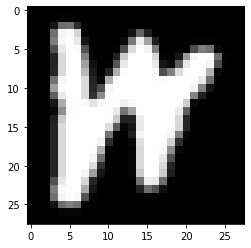

In [43]:
image, label = dataset[0]
plt.imshow(image[0, :, :], cmap = 'gray')

In [44]:
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(119800, 5000)

In [45]:
batch_size = 128

In [46]:
train_loader = DataLoader(train_ds, batch_size = batch_size, shuffle = True, num_workers = 3, pin_memory = True)
val_loader = DataLoader(val_ds, batch_size = batch_size, shuffle = True, num_workers = 3, pin_memory = True)

In [47]:
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = 3, pin_memory = True)

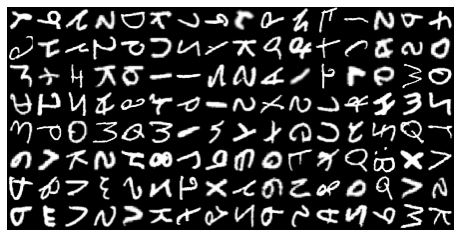

In [48]:
for images, _ in train_loader:
  plt.figure(figsize = (8, 16))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow = 8, padding = 0).permute(2, 1, 0))
  break

In [49]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [50]:
def to_device(data, device):
  if isinstance(data, (list, tuple)):
    return [to_device(x, device) for x in data]
  return data.to(device, non_blocking = True)

In [51]:
class DeviceDataLoader():
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    for batch in self.dl:
      yield to_device(batch, self.device)
  
  def __len__(self):
    return len(self.dl)

In [52]:
train_ddl = DeviceDataLoader(train_loader, device)
val_ddl = DeviceDataLoader(val_loader, device)
test_ddl = DeviceDataLoader(test_loader, device)

In [53]:
def find_accuracy(outputs, labels):
  _, preds = torch.max(outputs, dim =1)
  return ((preds == labels).sum()).item() / len(preds)

In [54]:
class Base_Class(nn.Module):
  def training_batch(self, batch):
    images, labels = batch
    labels = to_device(torch.tensor([x-1 for x in labels]), device)
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels)
    return loss

  def validation_batch(self, batch):
    images, labels = batch
    labels = to_device(torch.tensor([x-1 for x in labels]), device)
    outputs = self.forward(images)
    loss = F.cross_entropy(outputs, labels).item()
    accuracy = find_accuracy(outputs, labels)
    return {'val_loss' : loss, 'val_accuracy' : accuracy}

  def validation_end_epoch(self, outputs):
    epoch_loss = sum([x['val_loss'] for x in outputs]) / len(outputs)
    epoch_accuracy = sum([x['val_accuracy'] for x in outputs]) / len(outputs)
    return {'epoch_loss' : epoch_loss, 'epoch_accuracy' : epoch_accuracy}

In [57]:
class CNN_EMNIST(Base_Class):
  def __init__(self):
    super().__init__()
    self.network = nn.Sequential(
        nn.Conv2d(1, 8, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(8),
        nn.Conv2d(8, 32, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(32),
        nn.MaxPool2d(2), # 32*14*14

        nn.Conv2d(32, 128, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(128),
        nn.Conv2d(128, 256, kernel_size = 3, stride = 1, padding = 1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(256),
        nn.MaxPool2d(2), # 256*7*7

        nn.Flatten(),
        nn.Linear(256*7*7, 512),
        nn.ReLU(),
        nn.Linear(512, 32),
        nn.ReLU(),
        nn.Linear(32, 26)
    )

  def forward(self, images):
    return self.network(images)

In [58]:
model = CNN_EMNIST()
to_device(model, device)

CNN_EMNIST(
  (network): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(32, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Flatten()
  

In [59]:
@torch.no_grad()
def validate(model, val_ddl):
  model.eval()
  outputs = [model.validation_batch(batch) for batch in val_ddl]
  return model.validation_end_epoch(outputs)

def fit(model, epochs, learning_rate, train_ddl, val_ddl, optimization_func = torch.optim.SGD):
  torch.cuda.empty_cache()
  history = []
  optimizer = optimization_func(model.parameters(), learning_rate)
  for epoch in range(epochs):
    model.train()
    for batch in train_ddl:
      loss = model.training_batch(batch)
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
    result = validate(model, val_ddl)
    history.append(result)
    print('Epoch: {}, Validation loss: {:.5f}, Validation accuracy: {:.5f}'.format(epoch, result['epoch_loss'], result['epoch_accuracy']))
  return history

In [60]:
history = [validate(model, val_ddl)]
history

[{'epoch_accuracy': 0.041015625, 'epoch_loss': 3.263198447227478}]

In [61]:
history += fit(model, 5, 0.1, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.21076, Validation accuracy: 0.92910
Epoch: 1, Validation loss: 0.16303, Validation accuracy: 0.94336
Epoch: 2, Validation loss: 0.16992, Validation accuracy: 0.94551
Epoch: 3, Validation loss: 0.17047, Validation accuracy: 0.94844
Epoch: 4, Validation loss: 0.16487, Validation accuracy: 0.94727


In [62]:
history += fit(model, 5, 0.003, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.14757, Validation accuracy: 0.95156
Epoch: 1, Validation loss: 0.14619, Validation accuracy: 0.95371
Epoch: 2, Validation loss: 0.15746, Validation accuracy: 0.95098
Epoch: 3, Validation loss: 0.15064, Validation accuracy: 0.95078
Epoch: 4, Validation loss: 0.15146, Validation accuracy: 0.95215


In [63]:
history += fit(model, 5, 0.0001, train_ddl, val_ddl)

Epoch: 0, Validation loss: 0.14691, Validation accuracy: 0.95488
Epoch: 1, Validation loss: 0.16217, Validation accuracy: 0.95215
Epoch: 2, Validation loss: 0.14657, Validation accuracy: 0.95488
Epoch: 3, Validation loss: 0.14819, Validation accuracy: 0.95469
Epoch: 4, Validation loss: 0.16141, Validation accuracy: 0.95215


Text(0.5, 1.0, 'Accuracy vs No. of Epochs')

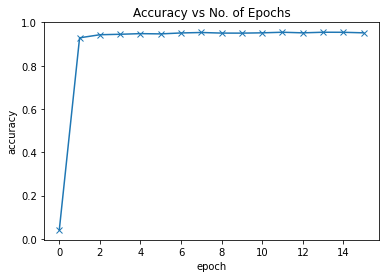

In [64]:
accuracies = [x['epoch_accuracy'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs No. of Epochs')

In [66]:
validate(model, test_ddl)

{'epoch_accuracy': 0.9488592791411042, 'epoch_loss': 0.15858421575255188}

In [67]:
torch.save(model.state_dict(), 'model.pth')